I'll use this file for the exact same purpose as others where you'd keep mean IAT, ST, and load fixed. Keep CV of IAT  and ST fixed.
And we had generated datasets where both lam_kurt and mu_kurt where allowed to vary.

That is all so well for 3D plots. For the 2D plots for of RT vs CV sq of IAT OR RT vs CV sq of ST, we would want to keep
either the lam_kurt or mu_kurt fixed as well depending on which 2D graph we're plotting.

So I'll replace the generic expressions for q, mu1 and mu2 with some constant value while plotting for RT vs CV sq of IAT and vice versa

In [163]:
import numpy as np
import sympy as sp
import pandas as pd
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt


from sympy import solve, Eq, symbols, re

lam1,lam2 ,p, coeffIAT2 = symbols('lam1 lam2 p coeffIAT2')

coeffIAT2 = 16
coeffST2_arr = [ 1.21, 4, 25, 64]

#coeffIST2 = 16
#coeffIAT2_arr = [ 1.21, 4, 25, 64]

In [164]:
def compute_kurtosis_H2(lam1 , lam2, p) :
    
    moment1 = (p/lam1+ (1-p)/lam2)
    moment2 = (2*p/lam1**2 + 2*(1-p)/lam2**2)
    moment3 = (6*p/lam1**3 + 6*(1-p)/lam2**3)
    moment4 = (24*p/lam1**4 + 24*(1-p)/lam2**4)
    
    kurtosis_num = moment4 - 4*moment1*moment3 + 6*(moment1**2)*moment2 - 3*(moment1**4) 
    kurtosis_deno = (moment2 - moment1**2)**2

    return (kurtosis_num / kurtosis_deno)

In [165]:
compute_kurtosis_H2(2.248023,0.039512 ,0.917342)


73.7331475571506

In [166]:
def calculatecoeff_var(lam1, lam2, p) :
    dist_mean =  p/lam1+ (1-p)/lam2
    dist_var = (2*p/lam1**2 + 2*(1-p)/lam2**2) - dist_mean**2
    dist_sd = abs(np.sqrt(dist_var))
    
    if (dist_sd / dist_mean) >= 1 :
        return(dist_sd/dist_mean)
    else :
        print("Please check your inputs. Coefficient of variance < 1")
        return -100

In [167]:
calculatecoeff_var(3.1760,0.054011 ,0.962)

4.990748417986152

In [168]:
#Implementing the Tarasov H2/H2/1 RT
def Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    for k in range(min(len(p_arr), len(q_arr))) : 
        a_0 = (lam1_arr[k]*lam2_arr[k])
        a_1 = p_arr[k]*lam1_arr[k] + (1-p_arr[k])*lam2_arr[k]
        b_0 = (mu1_arr[k]*mu2_arr[k])
        b_1 = q_arr[k]*mu1_arr[k] + (1-q_arr[k])*mu2_arr[k]

        c_0 = a_0*b_1 - a_1*b_0 - a_0*(mu1_arr[k]+mu2_arr[k]) + b_0*(lam1_arr[k] + lam2_arr[k])
        c_1 = -a_1*b_1 -a_0 - b_0  + (lam1_arr[k] + lam2_arr[k])*(mu1_arr[k] + mu2_arr[k])
        c_2 = lam1_arr[k] + lam2_arr[k] - mu1_arr[k] - mu2_arr[k]
        
        x = symbols('x')
        expr = x**3-c_2*x**2-c_1*x-c_0


        sol = solve(expr)
        #print(sol)
        
        #calculate wait time in queue Wq
        
        Wq = (-1/re(sol[0])) + (-1/re(sol[1])) - (1/mu1_arr[k]) - (1/mu2_arr[k]) 
        
        #calculate response time in queue W

        W = Wq + (q_arr[k]/mu1_arr[k]+ (1-q_arr[k])/mu2_arr[k])
        WTarasov_arr.append(W)

        if k == 0 :
            print("In order lam1 lam2 p", lam1_arr[k], lam2_arr[k], p_arr[k])
            print("In order mu1 mu2 q", mu1_arr[k], mu2_arr[k], q_arr[k])
            print("RT ", W)

    return WTarasov_arr

In [169]:
def MAM_2server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    
    
    mu_CV_arr = []
    lam_CV_arr = []
    for k in range(min(len(p_arr), len(q_arr))) :  
        
            
        if calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]) >=1 : 
            lam_CV_arr.append(calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]))

        if calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]) >=1 :
            mu_CV_arr.append(calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]))
        else :
            continue

        lam1 = lam1_arr[k]
        lam2 = lam2_arr[k]
        p = p_arr[k]

        mu1 = mu1_arr[k]
        mu2 = mu2_arr[k]
        q = q_arr[k]

        b1 = 2*mu1*(1-q)
        b2 = 2*mu2*(1-q)
        b3 = 2*mu1*q
        b4 = 2*mu2*q
        f1 = lam1*(1-p)
        f2 = lam2*(1-p)
        f3 = lam1*p
        f4 = lam2*p

        #Initializing forward, backward and initial arrays
        L_0 = np.transpose(np.array([[-(lam1), 0],
                       [0, -(lam2)]]))
       # print(L_0)
        #F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
        #               [lam2*(1-p)*(1-q), lam2*p*(1-q), lam2*p*q, lam2*(1-p)*q]])

        F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
                      #[lam2*p*q, lam2*(p)*(1-q), lam2*(1-p)*(q), lam2*(1-p)*(1-q)],
                       [lam2*(p)*(q), lam2*(1-p)*(q), lam2*(p)*(1-q), lam2*(1-p)*(1-q)]])
       # print(F_0)
        B_0 = np.array([[mu1, 0],
                       [mu1, 0],
                       [0, mu2],
                       [0, mu2]])
       # print(B_0)
        L = np.array([[-(lam1 + 2*mu1), 0, 0, 0],
                     [0, -(lam2 + 2*mu1), 0, 0],
                     [0, 0, -(lam1 + 2*mu2), 0],
                     [0, 0, 0, -(lam2 + 2*mu2)]])
        L_1 = np.array([[-(lam1 + mu1), 0, 0, 0],
                     [0, -(lam2 + mu1), 0, 0],
                     [0, 0, -(lam1 + mu2), 0],
                     [0, 0, 0, -(lam2 + mu2)]])
       # print(L)
       # print(L_1)
        F = np.array([[f3, f1, 0, 0],
                     [f4, f2, 0, 0],
                     [0, 0, f3, f1],
                     [0, 0, f4, f2]])
        #print(F)
        B = np.array([[b3, 0, b1, 0],
                     [0, b3, 0, b1],
                     [b4, 0, b2, 0],
                     [0, b4, 0, b2]])
        B1 = np.array([[mu1*q, 0, mu1*(1-q), 0],
                     [0, mu1*q, 0, mu1*(1-q)],
                     [mu2*q, 0, mu2*(1-q), 0],
                     [0, mu2*q, 0, mu2*(1-q)]])
        #print(B)
        #print(B1)
        R_0 = np.zeros((4, 4))
        #print(R_0)

        R_prev = R_0
        n = 0
        flag = 0

        while flag == 0 :
            diff = []
            if n > 0:
                R_prev = R

            R_2 = np.matmul(R_prev,R_prev)
            R_mid = -(np.matmul(R_2,B) + F)
            #print(R_mid)
            R = np.matmul(R_mid, np.linalg.inv(L))

            for (i,j) in zip(R_prev, R) :
                for (k,l) in zip(i,j) :
                    diff.append(abs(k-l))

            max = np.max(diff)
            #print("Max is", max)
            if (max < 10**-7) :

                flag =1
                break
            n += 1
       # print(R,n)

        #Computing steady state distribution for state 0 and 1

        #Creating (I - R)^-1 = psi
        I = np.eye(4)
        psi_full = np.linalg.inv(I - R)
        psi = np.matmul(psi_full,np.ones((4,1), dtype=int))
        psi = np.vstack([np.ones((6,1), dtype=int), psi])
        #print("Psi :",psi)

        #Creating L + RB
        RB = np.matmul(R, B)
        LRB = np.add(L, RB)
       # print(LRB)

        #Creating stacked version of [0  F  L+RB]T = phi
        phi_2 = np.vstack([np.zeros((2, 4)), F, LRB])


        #Creating stacked version of [F_0 L_1 B]
        phi_1 = np.vstack([F_0, L_1, B])

        phi = np.hstack([phi_1, phi_2])
        #print("Phi :",phi)

        #Solving for pi_0 and pi_1
        A = np.array([0, -(lam2), 0, 0, mu2, mu2, 0, 0, 0, 0])
        A = A[..., None] 

        A = np.hstack([psi,A, phi])
        b = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
       # print(A,b)
        """
        steady_pi = np.linalg.solve(np.transpose(A), b)
        print(steady_pi)
        """
        steady_pi = np.matmul(b, np.linalg.inv(A)) 
        #print(steady_pi)
        #print(b.shape)

        lam_avg = (p/(lam1) + (1-p)/(lam2))


        pi_1 = [steady_pi[2], steady_pi[3], steady_pi[4], steady_pi[5]]
       # print("pi_1 : ", pi_1)

        pi_2 = [steady_pi[6], steady_pi[7], steady_pi[8], steady_pi[9]]
       # print("pi_2 : ", pi_2)

        squareI_R = np.matmul((I - R), (I - R)) 
        W_num_1 = np.matmul(np.linalg.inv(squareI_R), np.ones((4,1), dtype=int))
        W_num_1 = np.matmul(R, W_num_1)
        #print(W_num_1)

        W_num_2 = 2*np.matmul(np.linalg.inv(I - R), np.ones((4,1), dtype=int))
        #print(W_num_2)
        W_num = np.dot(pi_2, W_num_1 + W_num_2)

        W_num = W_num + np.matmul(pi_1, np.ones((4,1), dtype=int))
        W = W_num * lam_avg
        WTarasov_arr.append(abs(W))


    
    
        

    return WTarasov_arr
    
    

In [170]:
def MAM_3server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    
    
    mu_CV_arr = []
    lam_CV_arr = []
    for k in range(min(len(p_arr), len(q_arr))) :  
        
            
        if calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]) >=1 : 
            lam_CV_arr.append(calculatecoeff_var(lam1_arr[k], lam2_arr[k], p_arr[k]))

        if calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]) >=1 :
            mu_CV_arr.append(calculatecoeff_var(mu1_arr[k], mu2_arr[k], q_arr[k]))
        else :
            continue
            
        lam1 = lam1_arr[k]
        lam2 = lam2_arr[k]
        p = p_arr[k]

        mu1 = mu1_arr[k]
        mu2 = mu2_arr[k]
        q = q_arr[k]
        
        b1 = 3*mu1*(1-q)
        b2 = 3*mu2*(1-q)
        b3 = 3*mu1*q
        b4 = 3*mu2*q
        f1 = lam1*(1-p)
        f2 = lam2*(1-p)
        f3 = lam1*p
        f4 = lam2*p

        #Initializing forward, backward and initial arrays
        L_0 = np.transpose(np.array([[-(lam1), 0],
                       [0, -(lam2)]]))
       # print(L_0)
        #F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
        #               [lam2*(1-p)*(1-q), lam2*p*(1-q), lam2*p*q, lam2*(1-p)*q]])

        F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
                      #[lam2*p*q, lam2*(p)*(1-q), lam2*(1-p)*(q), lam2*(1-p)*(1-q)],
                       [lam2*(p)*(q), lam2*(1-p)*(q), lam2*(p)*(1-q), lam2*(1-p)*(1-q)]])
       # print(F_0)
        B_0 = np.array([[mu1, 0],
                       [mu1, 0],
                       [0, mu2],
                       [0, mu2]])
       # print(B_0)
        L = np.array([[-(lam1 + 3*mu1), 0, 0, 0],
                     [0, -(lam2 + 3*mu1), 0, 0],
                     [0, 0, -(lam1 + 3*mu2), 0],
                     [0, 0, 0, -(lam2 + 3*mu2)]])
        L_1 = np.array([[-(lam1 + mu1), 0, 0, 0],
                     [0, -(lam2 + mu1), 0, 0],
                     [0, 0, -(lam1 + mu2), 0],
                     [0, 0, 0, -(lam2 + mu2)]])
        L_2 = np.array([[-(lam1 + 2*mu1), 0, 0, 0],
                     [0, -(lam2 + 2*mu1), 0, 0],
                     [0, 0, -(lam1 + 2*mu2), 0],
                     [0, 0, 0, -(lam2 + 2*mu2)]])
       # print(L)
       # print(L_1)
       # print(L_2)
        F = np.array([[f3, f1, 0, 0],
                     [f4, f2, 0, 0],
                     [0, 0, f3, f1],
                     [0, 0, f4, f2]])
       # print(F)
        B = np.array([[b3, 0, b1, 0],
                     [0, b3, 0, b1],
                     [b4, 0, b2, 0],
                     [0, b4, 0, b2]])
        B_1 = np.array([[2*mu1*q, 0, 2* mu1*(1-q), 0],
                     [0, 2*mu1*q, 0, 2*mu1*(1-q)],
                     [2*mu2*q, 0, 2*mu2*(1-q), 0],
                     [0, 2*mu2*q, 0, 2*mu2*(1-q)]])
       # print(B)
       # print(B_1)
        R_0 = np.zeros((4, 4))
       # print(R_0)

        # Computing matrix R
        R_prev = R_0
        n = 0
        flag = 0

        while flag == 0 :
            diff = []
            if n > 0:
                R_prev = R

            R_2 = np.matmul(R_prev,R_prev)
            R_mid = -(np.matmul(R_2,B) + F)
            #print(R_mid)
            R = np.matmul(R_mid, np.linalg.inv(L))

            for (i,j) in zip(R_prev, R) :
                for (k,l) in zip(i,j) :
                    diff.append(abs(k-l))

            max = np.max(diff)
            #print("Max is", max)
            if (max < 10**-7) :

                flag =1
                break
            n += 1
        #print(R,n)

        #Computing steady state distribution for state 0 and 1 and 2

        #Creating (I - R)^-1 = psi
        I = np.eye(4)
        psi_full = np.linalg.inv(I - R)
        psi = np.matmul(psi_full, np.ones((4,1), dtype=np.int64))
        psi = np.vstack([np.ones((10,1), dtype=np.int64), psi])
      #  print("Psi :",psi)

        #Creating L + RB
        RB = np.matmul(R, B)
        LRB = np.add(L, RB)
       # print(LRB)

        #Creating stacked version of [0 0 F  L+RB]T = phi
        phi_3 = np.vstack([np.zeros((2, 4)), np.zeros((4, 4)), F, LRB])

        #Creating stacked version of [0  F L2 B]T = phi
        phi_2 = np.vstack([np.zeros((2, 4)), F, L_2, B])

        #Creating stacked version of [F_0 L_1 B_1 0]
        phi_1 = np.vstack([F_0, L_1, B_1, np.zeros((4, 4))])

        phi = np.hstack([phi_1, phi_2, phi_3])
      #  print("Phi :",phi)

        #Solving for pi_0 and pi_1 and pi_2
        A = np.array([0, -(lam2), 0, 0, mu2, mu2, 0, 0, 0, 0, 0, 0, 0, 0])
        A = A[..., None] 

        A = np.hstack([psi,A, phi])
        b = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
      #  print(A,b)
        """
        steady_pi = np.linalg.solve(np.transpose(A), b)
        print(steady_pi)
        """
        steady_pi = np.matmul(b, np.linalg.inv(A)) 
       # print(steady_pi)
       # print(b.shape)

        lam_avg = (p/(lam1) + (1-p)/(lam2))

        pi_1 = [steady_pi[2], steady_pi[3], steady_pi[4], steady_pi[5]]
       # print("pi_1 : ", pi_1)

        pi_2 = [steady_pi[6], steady_pi[7], steady_pi[8], steady_pi[9]]
       # print("pi_2 : ", pi_2)

        pi_3 = [steady_pi[10], steady_pi[11], steady_pi[12], steady_pi[13]]
       # print("pi_3 : ", pi_3)

        squareI_R = np.matmul((I - R), (I - R)) 
        W_num_1 = np.matmul(np.linalg.inv(squareI_R), np.ones((4,1), dtype=int))
        W_num_1 = np.matmul(R, W_num_1)
        #print(W_num_1)

        W_num_2 = 3*np.matmul(np.linalg.inv(I - R), np.ones((4,1), dtype=int))
        #print(W_num_2)
        W_num = np.dot(pi_3, W_num_1 + W_num_2)

        W_num = W_num + np.matmul(pi_1, np.ones((4,1), dtype=int)) + 2*np.matmul(pi_2, np.ones((4,1), dtype=int)) 
        W = W_num * lam_avg

        
        WTarasov_arr.append(abs(W))


    
    
        

    return WTarasov_arr
    
    

# 2D plots fixed IAT (take specific values of p, lam1, lam2), changing ST

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 2.248023 0.039512 0.917342
In order mu1 mu2 q 1.7020724698273322 0.7970939800974224 0.3816231593985031
RT  10.4857381170849
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 2.248023 0.039512 0.917342
In order mu1 mu2 q 1.8978037511966142 0.23976538995294888 0.8701705150263158
RT  11.6232997866562
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 2.248023 0.039512 0.917342
In order mu1 mu2 q 6.555292423041843 0.06596261552204498 0.9435316698206634
RT  20.0619040225318
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 2.248023 0.039512 0.917342
In order mu1 mu2 q 1.1087613941762404 0.0031043866085402063 0.9996946273452835
RT  31.4318345870266
False
False


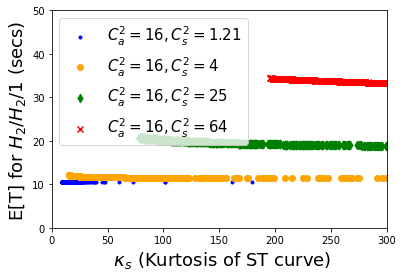

In [124]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.917342]*1000
    lam1_arr = [2.248023]*1000
    lam2_arr = [0.039512]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 16, C_s^2 = 1.21$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 16, C_s^2 = 4$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 16, C_s^2 = 25$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 16, C_s^2 = 64$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r" $\kappa_s$ (Kurtosis of ST curve)", fontsize = 18)
    plt.ylabel("E[T] for $H_2/H_2/1$ (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_1_fixedmean_CVa2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




final_df.to_csv('DetailsH2_H2_1_fixedmean_CVa2D_load0.4.csv', index= False)

# H2/H2/2

Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
False
False


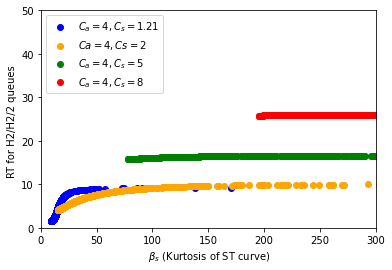

In [160]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.917342]*1000
    lam1_arr = [2.248023]*1000
    lam2_arr = [0.039512]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))
  
    #print(mu_coeff_var_arr)
    W_exact = MAM_2server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    print("Length of W_exact", len(W_exact))
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        mu_kurt_arr = mu_kurt_arr[100:]
        W_exact = W_exact[100:]
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a = 4, C_s = 1.21$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        mu_kurt_arr = mu_kurt_arr[100:]
        W_exact = W_exact[100:]
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$Ca = 4, Cs = 2$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        mu_kurt_arr = mu_kurt_arr[50:]
        W_exact = W_exact[50:]
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a = 4, C_s = 5$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a = 4, C_s = 8$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left')

    plt.xlabel(r" $\beta_s$ (Kurtosis of ST curve)")
    plt.ylabel("RT for H2/H2/2 queues ")
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_2_fixedmean_CVa2D_load0.4.pdf", dpi = 200)
plt.show()




final_df.to_csv('DetailsH2_H2_2_fixedmean_CVa2D_load0.4.csv', index= False)

# H2/H2/3

Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of ST :  1000 1000 1000
Length of W_exact 1000
False
False


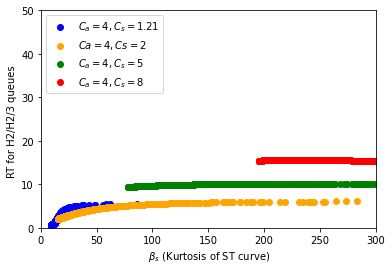

In [171]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['q', 'mu1', 'mu2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffST2 in coeffST2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= [0.917342]*1000
    lam1_arr = [2.248023]*1000
    lam2_arr = [0.039512]*1000
    lam_kurt_arr = []
    

    q_arr = []
    mu1_arr = []
    mu2_arr = []
    mu_kurt_arr = []
   
    

    while i < 1000 :
        #p = np.random.rand()
        #lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        #lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        q = np.random.rand()
        mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if mu1 <= 0 or mu2 <= 0:
            continue
        
        if calculatecoeff_var(mu1, mu2, q) >= 1 :
            
            lam_kurt_arr.append(compute_kurtosis_H2(lam1_arr[0], lam2_arr[0], p_arr[0]))

            q_arr.append(q)
            mu1_arr.append(mu1)
            mu2_arr.append(mu2)
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1, mu2, q))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))
  
    #print(mu_coeff_var_arr)
    W_exact = MAM_3server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    print("Length of W_exact", len(W_exact))
    
    store_df = pd.DataFrame({'q' : q_arr,
                             'mu1' : mu1_arr, 
                             'mu2' : mu2_arr,
                            'coeffIAT_sq' : [16] * len(W_exact),
                            'coeffST_sq' : [coeffST2] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffST2 == 1.21 :
        mu_kurt_arr = mu_kurt_arr[100:]
        W_exact = W_exact[100:]
        plt.scatter(mu_kurt_arr, W_exact, color = 'blue', label = r'$C_a = 4, C_s = 1.21$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 4 :
        mu_kurt_arr = mu_kurt_arr[200:]
        W_exact = W_exact[200:]
        plt.scatter(mu_kurt_arr, W_exact, color = 'orange', label = r'$Ca = 4, Cs = 2$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 25 :
        mu_kurt_arr = mu_kurt_arr[50:]
        W_exact = W_exact[50:]
        plt.scatter(mu_kurt_arr, W_exact,  color = 'green', label = r'$C_a = 4, C_s = 5$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffST2 == 64 :
        plt.scatter(mu_kurt_arr, W_exact, color = 'red', label = r'$C_a = 4, C_s = 8$')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left')

    plt.xlabel(r" $\beta_s$ (Kurtosis of ST curve)")
    plt.ylabel("RT for H2/H2/3 queues ")
    plt.xlim(0, 300)
    plt.ylim(0, 50)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_3_fixedmean_CVa2D_load0.4.pdf", dpi = 200)
plt.show()




final_df.to_csv('DetailsH2_H2_3_fixedmean_CVa2D_load0.4.csv', index= False)

In [161]:
import pandas as pd

df = pd.read_csv('DetailsH2_H2_2_fixedmean_CVa2D_load0.4.csv')
df["Response time"] = df["Response time"].apply(lambda x: float(x.strip('[]')))
df = df.sort_values(by='mu_kurt')


filtered_df_121 = df[(df["coeffST_sq"] == 1.21) & (df["mu_kurt"] > 25)]

lam_kurt_121 = filtered_df_121["lam_kurt"]
mu_kurt_121 = filtered_df_121["mu_kurt"]
RT_121 = filtered_df_121["Response time"]

print(filtered_df_121.head())

filtered_df_4 = df[(df["coeffST_sq"] == 4) & (df["mu_kurt"] > 35)]

lam_kurt_4 = filtered_df_4["lam_kurt"]
mu_kurt_4 = filtered_df_4["mu_kurt"]
RT_4 = filtered_df_4["Response time"]
print(filtered_df_4.head())

filtered_df_25 = df[(df["coeffST_sq"] == 25)]

lam_kurt_25 = filtered_df_25["lam_kurt"]
mu_kurt_25 = filtered_df_25["mu_kurt"]
RT_25 = filtered_df_25["Response time"]
print(filtered_df_25.head())

filtered_df_64 = df[(df["coeffST_sq"] == 64)]

lam_kurt_64 = filtered_df_64["lam_kurt"]
mu_kurt_64 = filtered_df_64["mu_kurt"]
RT_64 = filtered_df_64["Response time"]

             q       mu1       mu2  coeffIAT_sq  coeffST_sq   lam_kurt  \
1192  0.964003  1.066799  0.373570           16        1.21  73.733148   
192   0.964003  1.066799  0.373570           16        1.21  73.733148   
440   0.964096  1.066704  0.373257           16        1.21  73.733148   
1440  0.964096  1.066704  0.373257           16        1.21  73.733148   
559   0.965745  1.064994  0.367574           16        1.21  73.733148   

        mu_kurt  Response time  
1192  25.172490       8.008192  
192   25.172490       8.008192  
440   25.197514       8.011214  
1440  25.197514       8.011214  
559   25.661197       8.065089  
             q       mu1       mu2  coeffIAT_sq  coeffST_sq   lam_kurt  \
3321  0.820874  2.337096  0.276103           16         4.0  73.733148   
2321  0.820874  2.337096  0.276103           16         4.0  73.733148   
3359  0.821380  2.331733  0.275759           16         4.0  73.733148   
2359  0.821380  2.331733  0.275759           16         4.0  

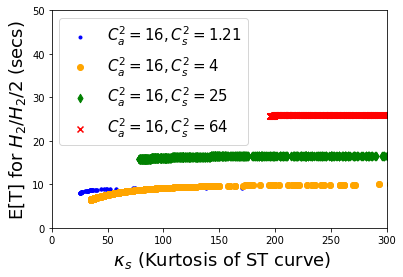

In [162]:
import matplotlib.pyplot as plt

plt.scatter(mu_kurt_121, RT_121, color = 'blue', label = r'$C_a^2 = 16, C_s^2 = 1.21$', marker = '.')
plt.scatter(mu_kurt_4, RT_4, color = 'orange', label = r'$C_a^2 = 16, C_s^2 = 4$', marker = 'o')
plt.scatter(mu_kurt_25, RT_25, color = 'green', label = r'$C_a^2 = 16, C_s^2 = 25$', marker = 'd')
plt.scatter(mu_kurt_64, RT_64, color = 'red', label = r'$C_a^2 = 16, C_s^2 = 64$', marker = 'x')
       


plt.xlabel(r" $\kappa_s$ (Kurtosis of ST curve)", fontsize = 18)
plt.ylabel("E[T] for $H_2/H_2/2$ (secs)", fontsize = 18)
plt.xlim(0, 300)
plt.ylim(0, 50)
plt.legend(loc = 'upper left', prop = { "size": 15 })
plt.savefig("DetailsH2_H2_2_fixedmean_CVa2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()

# 2D plots fixed ST (take specific values of q, mu1, mu2), changing IAT

In [117]:
coeffIST2 = 16
coeffIAT2_arr = [ 1.21, 4, 25, 64]

Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 0.48369642928747975 0.24894150485057903 0.7781147954090427
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  14.0269725738955
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 3.47682699363915 0.14842181302095564 0.6569893671372518
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  21.9489459430887
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 1.6564186015741587 0.02378063715424214 0.9542480412240587
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  75.4618083065311
Lengths for parameter vectors of IAT :  1000 1000 1000
In order lam1 lam2 p 0.8126244596796854 0.006345559334412415 0.9918813828628441
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  130.014952295415
False
False


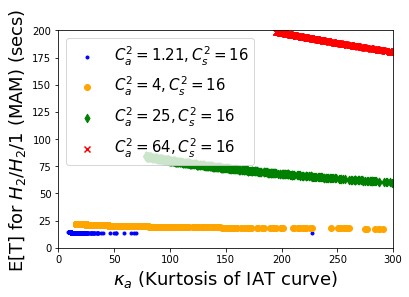

In [173]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['p', 'lam1', 'lam2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= [0.781]*1000
    mu1_arr = [2.04463]*1000
    mu2_arr = [0.15960]*1000
    mu_kurt_arr = []
    

    p_arr = []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
   
    

    while i < 1000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        #q = np.random.rand()
        #mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        #mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if lam1 <= 0 or lam2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >= 1 :
            
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1_arr[0], mu2_arr[0], q_arr[0]))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'p' : p_arr,
                             'lam1' : lam1_arr, 
                             'lam2' : lam2_arr,
                            'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 1.21, C_s^2 = 16$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 4 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 4, C_s^2 = 16$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 25 :
        plt.scatter(lam_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 25, C_s^2 = 16$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 64 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 64, C_s^2 = 16$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r"$\kappa_a$ (Kurtosis of IAT curve)", fontsize = 18)
    plt.ylabel("E[T] for $H_2/H_2/1$ (MAM) (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 200)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_1_fixedmean_CVs2D_load0.4(MAM).pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




#final_df.to_csv('DetailsH2_H2_1_fixedmean_CVs2D_load0.4.csv', index= False)

# H2/H2/2

Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
False
False


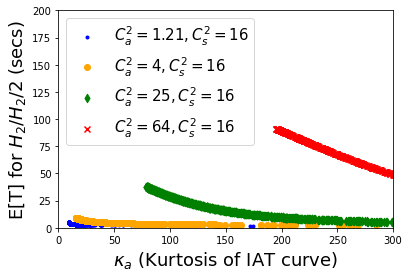

In [122]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['p', 'lam1', 'lam2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= [0.781]*1000
    mu1_arr = [2.04463]*1000
    mu2_arr = [0.15960]*1000
    mu_kurt_arr = []
    

    p_arr = []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
   
    

    while i < 1000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        #q = np.random.rand()
        #mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        #mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if lam1 <= 0 or lam2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >= 1 :
            
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1_arr[0], mu2_arr[0], q_arr[0]))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = MAM_2server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'p' : p_arr,
                             'lam1' : lam1_arr, 
                             'lam2' : lam2_arr,
                            'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 1.21, C_s^2 = 16$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 4 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 4, C_s^2 = 16$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 25 :
        plt.scatter(lam_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 25, C_s^2 = 16$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 64 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 64, C_s^2 = 16$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r"$\kappa_a$ (Kurtosis of IAT curve)", fontsize = 18)
    plt.ylabel("E[T] for $H_2/H_2/2$ (secs) ", fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 200)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_2_fixedmean_CVs2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




final_df.to_csv('DetailsH2_H2_2_fixedmean_CVs2D_load0.4.csv', index= False)

# H2/H2/3

Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
Lengths for parameter vectors of IAT :  1000 1000 1000
False
False


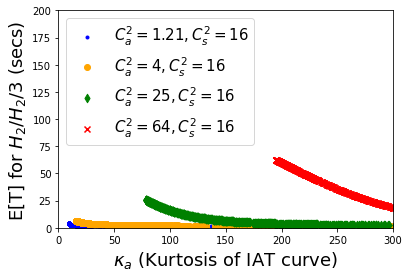

In [123]:
#Fixed IAT, changing ST CV
W_exact = []

final_df = pd.DataFrame(columns = ['p', 'lam1', 'lam2', 'coeffIAT_sq', 'coeffST_sq', 'lam_kurt', 'mu_kurt', 'Response time'])
for coeffIAT2 in coeffIAT2_arr :
    
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= [0.781]*1000
    mu1_arr = [2.04463]*1000
    mu2_arr = [0.15960]*1000
    mu_kurt_arr = []
    

    p_arr = []
    lam1_arr = []
    lam2_arr = []
    lam_kurt_arr = []
   
    

    while i < 1000 :
        p = np.random.rand()
        lam2 = 0.4*(2.0*p + 1.41421*math.sqrt(-p*(coeffIAT2 - 1.0)*(p - 1.0)) - 2.0)/(coeffIAT2*p + p - 2.0)  
        lam1 = (0.8*p + 0.56568*math.sqrt(p*(-coeffIAT2*p + coeffIAT2 + p - 1.0)))/(coeffIAT2*p - coeffIAT2 + p + 1.0)

       

        #q = np.random.rand()
        #mu2 = (2*q + math.sqrt(2)*math.sqrt(-q*(coeffST2 - 1)*(q - 1)) - 2)/(coeffST2*q + q - 2)  # Multiplying by 10 to scale the random numbers between 0 and 20
        #mu1 = (2*q + math.sqrt(2)*math.sqrt(q*(-coeffST2*q + coeffST2 + q - 1)))/(coeffST2*q - coeffST2 + q + 1)

        if lam1 <= 0 or lam2 <= 0:
            continue
        
        if calculatecoeff_var(lam1, lam2, p) >= 1 :
            
            p_arr.append(p)
            lam1_arr.append(lam1)
            lam2_arr.append(lam2)
            lam_kurt_arr.append(compute_kurtosis_H2(lam1, lam2, p))

            
            #if calculatecoeff_var(mu1, mu2, q) > 0  :
            mu_kurt_arr.append(compute_kurtosis_H2(mu1_arr[0], mu2_arr[0], q_arr[0]))
        

        i += 1

    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    #print(mu_coeff_var_arr)
    W_exact = MAM_3server(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    store_df = pd.DataFrame({'p' : p_arr,
                             'lam1' : lam1_arr, 
                             'lam2' : lam2_arr,
                            'coeffIAT_sq' : [coeffIAT2] * len(W_exact),
                            'coeffST_sq' : [16] * len(W_exact),
                            'lam_kurt' : lam_kurt_arr,
                            'mu_kurt' : mu_kurt_arr,
                            'Response time' : W_exact}
                            )
    final_df = final_df.append(store_df, ignore_index = True)
    #fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='3d')
    
    #plt.scatter(lam_kurt_arr, W_exact)
    
    if coeffIAT2 == 1.21 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'blue', label = r'$C_a^2 = 1.21, C_s^2 = 16$', marker = '.')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'red', label = 'Ca = 4, Cs = 1.21,')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 4 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'orange', label = r'$C_a^2 = 4, C_s^2 = 16$', marker = 'o')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'blue', label = 'Ca = 4, Cs = 2')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(10,100)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 25 :
        plt.scatter(lam_kurt_arr, W_exact,  color = 'green', label = r'$C_a^2 = 25, C_s^2 = 16$', marker = 'd')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'green', label = 'Ca = 4, Cs = 5')
        #ax1.set_xlim(10, 200)
        #ax1.set_ylim(70,150)
        #ax1.set_zlim(0,400)
        
    elif coeffIAT2 == 64 :
        plt.scatter(lam_kurt_arr, W_exact, color = 'red', label = r'$C_a^2 = 64, C_s^2 = 16$', marker = 'x')
        #ax1.scatter3D(lam_kurt_arr, mu_kurt_arr, W_exact, color = 'yellow', label = 'Ca = 4, Cs = 8')
        #ax1.set_xlim(100, 200)
        #ax1.set_ylim(100,200)
        #ax1.set_zlim(200,600)
        
        
    plt.legend(loc = 'upper left', prop = { "size": 15 })

    plt.xlabel(r"$\kappa_a$ (Kurtosis of IAT curve)", fontsize = 18)
    plt.ylabel("E[T] for $H_2/H_2/3$ (secs) ",fontsize = 18)
    plt.xlim(0, 300)
    plt.ylim(0, 200)
    final_df = final_df.append(store_df, ignore_index = True)
    
    
    #ax1.set_xlabel('Kurtosis of IAT curve')
    #ax1.set_ylabel('Kurtosis of ST curve')
    #ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for different Ca/Cs')
    #ax1.set_xlim(10, 200)
    #ax1.set_ylim(10,100)
    #ax1.set_zlim(0,400)

    
print(any(num1 < 0 for num1 in W_exact))
print(any(num2 < 0 for num2 in W_exact))

plt.savefig("DetailsH2_H2_3_fixedmean_CVs2D_load0.4.pdf", dpi = 200,  bbox_inches = "tight")
plt.show()




final_df.to_csv('DetailsH2_H2_3_fixedmean_CVs2D_load0.4.csv', index= False)

1. For green curve, take couple of points and run on Matrix method H2/H2/1 

# Verifying above graph with Matrix analysis code

In [185]:
import pandas as pd

df = pd.read_csv("DetailsH2_H2_1_fixedmean_CVa(constantIATparams).csv")

df_25 = df[(df['coeffST_sq'] == 1.21) & (df['mu_kurt'] > 20)]
df_25.sort_values(by = 'mu_kurt')

df_25.head(50)

,q,mu1,mu2,coeffIAT_sq,coeffST_sq,lam_kurt,mu_kurt,Response time
4,0.967187,1.063473,0.362419,16,1.21,70.733148,23.099404,10.469066
28,0.982240,1.045557,0.293270,16,1.21,70.733148,31.207582,10.466864
35,0.958796,1.072012,0.390153,16,1.21,70.733148,20.928013,10.469927
66,0.988695,1.035893,0.248115,16,1.21,70.733148,40.267631,10.465369
108,0.989917,1.033809,0.237489,16,1.21,70.733148,43.145702,10.465010
119,0.976882,1.052464,0.321918,16,1.21,70.733148,27.250636,10.467787
131,0.964080,1.066720,0.373309,16,1.21,70.733148,22.193357,10.469406
132,0.955082,1.075584,0.400932,16,1.21,70.733148,20.194316,10.470259
139,0.991940,1.030088,0.217636,16,1.21,70.733148,49.645896,10.464331
153,0.962486,1.068344,0.378596,16,1.21,70.733148,21.779356,10.469570


In [38]:


df_25_p = df_25['p'].to_numpy()
df_25_lam1 = df_25['lam1'].to_numpy()
df_25_lam2 = df_25['lam2'].to_numpy()
df_25_lam_kurt = df_25['lam_kurt'].to_numpy()


len_IAT = len(df_25_p)
print(len_IAT)

q = 0.781
mu1 = 2.04463
mu2 = 0.15960

2000


In [16]:
df_121 = df[(df['coeffIAT_sq'] == 1.21) & (df['lam_kurt'] > 25)]
df_121.sort_values(by = "lam_kurt")

df_121_p = df_121['p'].to_numpy()
df_121_lam1 = df_121['lam1'].to_numpy()
df_121_lam2 = df_121['lam2'].to_numpy()
df_121_lam_kurt = df_121['lam_kurt'].to_numpy()


len_IAT = len(df_121)
print(len_IAT)

q = 0.781
mu1 = 2.04463
mu2 = 0.15960

df_121.head(100)

68


,p,lam1,lam2,coeffIAT_sq,coeffST_sq,lam_kurt,mu_kurt,Response time
54,0.978080,0.420393,0.126401,1.21,16,27.985050,26.169666,13.9439590184272
66,0.996590,0.407728,0.061162,1.21,16,90.325563,26.169666,13.8403524269389
72,0.985585,0.416314,0.108713,1.21,16,34.983024,26.169666,13.9236854321943
90,0.986299,0.415883,0.106686,1.21,16,36.002621,26.169666,13.9210957079394
119,0.978208,0.420329,0.126142,1.21,16,28.068026,26.169666,13.9436881238503
...,...,...,...,...,...,...,...,...
1776,0.973249,0.422709,0.135386,1.21,16,25.385829,26.169666,13.9529125836023
1839,0.974921,0.421928,0.132435,1.21,16,26.184686,26.169666,13.9500592232582
1842,0.981565,0.418588,0.118890,1.21,16,30.596502,26.169666,13.9358204424827
1861,0.992872,0.411292,0.082911,1.21,16,53.772880,26.169666,13.8853454251330


In [46]:
compute_kurtosis_H2(2.04463 , 0.15960, 0.781)

26.169666343765634

In [51]:
i = 0
W_arr = []



while i < 2000:
    p = df_121_p[i]
    lam1 = df_121_lam1[i]
    lam2 = df_121_lam2[i]
    
    print("p lam1 lam2", p, lam1, lam2)
    
    q = 0.781
    mu1 = 2.04463
    mu2 = 0.15960
    
    b1 = mu1*(1-q)
    b2 = mu2*(1-q)
    b3 = mu1*q
    b4 = mu2*q
    f1 = lam1*(1-p)
    f2 = lam2*(1-p)
    f3 = lam1*p
    f4 = lam2*p

    L_0 = np.transpose(np.array([[-(lam1), 0],
               [0, -(lam2)]]))
    #print("L :", L_0)
#F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
#             [lam2*(1-p)*(1-q), lam2*p*(1-q), lam2*p*q, lam2*(1-p)*q]])
    F_0 = np.array([[lam1*p*q, lam1*(1-p)*q, lam1*p*(1-q), lam1*(1-p)*(1-q)],
              [lam2*(p)*(q), lam2*(1-p)*(q), lam2*(p)*(1-q), lam2*(1-p)*(1-q)]])
               #[lam2*(1-p)*(1-q), lam2*(p)*(1-q), lam2*(1-p)*(q), lam2*(p)*(q)]])
    #print("F_0 :",F_0)
    B_0 = np.array([[mu1, 0],
               [mu1, 0],
               [0, mu2],
               [0, mu2]])
    #print(B_0)
    L = np.array([[-(lam1 + mu1), 0, 0, 0],
             [0, -(lam2 + mu1), 0, 0],
             [0, 0, -(lam1 + mu2), 0],
             [0, 0, 0, -(lam2 + mu2)]])
    L1 = np.array([[-(lam2 + mu2), 0, 0, 0],
             [0, -(lam2 + mu2), 0, 0],
             [0, 0, -(lam1 + mu2), 0],
             [0, 0, 0, -(lam2 + mu2)]])
    #print("L :",L)
   # print(L1)
    F = np.array([[f3, f1, 0, 0],
             [f4, f2, 0, 0],
             [0, 0, f3, f1],
             [0, 0, f4, f2]])
    #print("F :",F)
    B = np.array([[b3, 0, b1, 0],
             [0, b3, 0, b1],
             [b4, 0, b2, 0],
             [0, b4, 0, b2]])
    B1 = np.array([[mu1*(q), 0, mu1*(1-q), 0],
             [0, mu1*(q), 0, mu1*(1-q)],
             [mu2*(q), 0, mu2*(1-q), 0],
             [0, mu2*(q), 0, mu2*(1-q)]])
    #print("B :",B)
    #print(B1)
    R_0 = np.zeros((4, 4))
    #print(R_0)

    R_prev = R_0
    n = 0
    flag = 0

    while flag == 0:
        diff = []
        if n > 0:
            R_prev = R

        R_2 = np.matmul(R_prev, R_prev)
        R_mid = -(np.matmul(R_2, B) + F)
        R = np.matmul(R_mid, np.linalg.inv(L))

        for i_prev, i_curr in zip(R_prev, R):
            for k, l in zip(i_prev, i_curr):
                diff.append(abs(k - l))

        max_diff = np.max(diff)
        if max_diff < 10**-7:
            flag = 1
        n += 1

    I = np.identity(4)
    psi_full = np.linalg.inv(I - R)
    psi = np.matmul(psi_full,np.ones((4,1), dtype=np.int64))
    psi = np.vstack([np.ones((2,1), dtype=np.int64), psi])
    #print(psi)

    #Creating L + RB
    RB = np.matmul(R, B)
    LRB = np.add(L, RB)
    #print(LRB)

    #Creating stacked version of [F_0  L+RB]T = phi
    phi = np.vstack([F_0, LRB])
    #print(phi)

    #Solving for pi_0 and pi_1
    A = np.array([0, -(lam2), 0, 0, mu2, mu2])
    A = A[..., None] 

    A = np.hstack([psi,A, phi])
    b = np.array([1, 0, 0, 0, 0, 0])
    #print(A,b)
    """
    steady_pi = np.linalg.solve(np.transpose(A), b)
    print(steady_pi)
    """
    steady_pi = np.matmul(b, np.linalg.inv(A)) 
    #print(steady_pi)
    #print(b.shape)


    lam_avg = p/(lam1) + (1-p)/(lam2)
    lam_avg

    #Computing avg response time W

    pi_1 = [steady_pi[2], steady_pi[3], steady_pi[4], steady_pi[5]]
    print(pi_1)

    squareI_R = np.matmul((I - R), (I - R))
    W_num = np.matmul(np.linalg.inv(squareI_R), np.ones((4,1), dtype=int))
    #print(W_num)
    W_num = np.dot(pi_1, W_num)

    W = W_num * lam_avg *0.8
    print("The mean response time is: ", W)
    
    W_arr.append(W)
    
    i += 1

#print(W_arr)

p lam1 lam2 0.3 2.248023 0.039512
[0.008415499407813724, 0.04947388978415662, 0.004207365821179613, 0.14521083045954805]
The mean response time is:  [8.31058975]
p lam1 lam2 0.6 2.248023 0.039512
[0.01659161609338757, 0.036918772614842985, 0.008295051200958702, 0.10836030185492634]
The mean response time is:  [11.82619727]
p lam1 lam2 0.6 1.2480229999999999 0.039512
[0.022997892463161175, 0.03423459157032467, 0.015084840758494531, 0.10048196117302789]
The mean response time is:  [10.13230893]
p lam1 lam2 0.7121836037394701 0.5037742648470106 0.2649502397428147
[0.035892625860990124, 0.018175115630209168, 0.03866410991769925, 0.02772517066591764]
The mean response time is:  [11.85038429]
p lam1 lam2 0.8795726331655377 0.4544936556021336 0.21325462485287425
[0.04456540456997294, 0.007918909743215493, 0.05085621907079488, 0.013446853886585525]
The mean response time is:  [11.43182346]
p lam1 lam2 0.6140231132422808 0.5382925763365637 0.2839499086248817
[0.030696213612490062, 0.02420832126

[0.02644362242203362, 0.029196667334007803, 0.02647906054636171, 0.04198871077843702]
The mean response time is:  [12.25414218]
p lam1 lam2 0.8005626761761631 0.477174626470308 0.242540641355634
[0.040525236711475635, 0.012774470031947809, 0.04500329665838594, 0.020373074543653433]
The mean response time is:  [11.64950284]
p lam1 lam2 0.7491261932892574 0.492318339064944 0.2564203073613763
[0.037836773524471325, 0.015917294614845878, 0.04128816690925433, 0.024687318430316046]
The mean response time is:  [11.76875787]
p lam1 lam2 0.15749432755891246 1.5965465318522938 0.35084630725948995
[0.005616136293494505, 0.05729510802873657, 0.0032652144091585584, 0.07539671721369512]
The mean response time is:  [14.21179468]
p lam1 lam2 0.6790112751337732 0.5146623358864034 0.2718708681793495
[0.034140653958522116, 0.020206614958841126, 0.036337572561380906, 0.03042059019807737]
The mean response time is:  [11.92271381]
p lam1 lam2 0.4665276189505757 0.6120937444441443 0.3069785106276289
[0.02283

[0.04206525831090795, 0.01095191394143082, 0.04718746983594536, 0.017816611528018906]
The mean response time is:  [11.57464461]
p lam1 lam2 0.9862991167830932 0.4158829765547294 0.10668569846917206
[0.048313738143239776, 0.0010578951333534683, 0.057923780707140556, 0.002396580406338345]
The mean response time is:  [10.58712399]
p lam1 lam2 0.43644907933196864 0.6331191637897952 0.31124461089918537
[0.02122363457063029, 0.03546675824867836, 0.020103115848654617, 0.04976100504962019]
The mean response time is:  [12.5221651]
p lam1 lam2 0.8043745536291563 0.4760767843721188 0.24139119859607305
[0.04072327348769377, 0.012541312510114725, 0.04528159763983281, 0.02004848148937715]
The mean response time is:  [11.64022597]
p lam1 lam2 0.2629665012824596 0.8742860775309212 0.3351338744561661
[0.011805457319581122, 0.047716078218266095, 0.00934597936836494, 0.06436059386619038]
The mean response time is:  [13.25671227]
p lam1 lam2 0.7263283351413694 0.4993150160458146 0.2617991076281839
[0.0366

[0.007774017642340531, 0.05375229203454674, 0.005223331321879304, 0.07133644115603528]
The mean response time is:  [13.80446408]
p lam1 lam2 0.6871496508669744 0.5119295754796938 0.2702283580732481
[0.03457092492065891, 0.019707697616065223, 0.036905819456032316, 0.029761740709485875]
The mean response time is:  [11.9049896]
p lam1 lam2 0.7999205783357823 0.4773597846691031 0.24273234660690804
[0.04049185812050956, 0.012813738828094749, 0.04495645904800126, 0.020427676249685976]
The mean response time is:  [11.65105782]
p lam1 lam2 0.983987829846916 0.41724702938760055 0.11298815015613818
[0.04841688028299535, 0.001220869852936789, 0.05794227981788813, 0.0027097552421301704]
The mean response time is:  [10.65748647]
p lam1 lam2 0.8554402409778291 0.461470096883144 0.2236840598010703
[0.04335021045559963, 0.009408859265328464, 0.04905034710538889, 0.015613939067437233]
The mean response time is:  [11.50570812]
p lam1 lam2 0.5410127722228936 0.5701757554582455 0.2959017620934518
[0.02681

[0.025885785849604888, 0.029857358607878692, 0.025785792019857357, 0.04281834259837084]
The mean response time is:  [12.28038579]
p lam1 lam2 0.7641124546932365 0.4878278403199604 0.25265304517383136
[0.03862270923982334, 0.01500191338889087, 0.04236299621533008, 0.023441768340668863]
The mean response time is:  [11.73491984]
p lam1 lam2 0.541585016572273 0.5698965206155169 0.2958129987405327
[0.026842587840448226, 0.028725213367091385, 0.026976604856065987, 0.041395105158406886]
The mean response time is:  [12.2356426]
p lam1 lam2 0.3198199199393241 0.7583729021268399 0.3272800921410117
[0.014929168675969563, 0.043447159393179995, 0.012782693979503473, 0.05935135985627679]
The mean response time is:  [12.95610024]
p lam1 lam2 0.3202384132827094 0.757720439013208 0.3272228621416401
[0.014951964981139633, 0.04341696446554357, 0.012808336405291621, 0.05931565299090732]
The mean response time is:  [12.95417754]
p lam1 lam2 0.24966348030208 0.9127235599220602 0.33700832586498275
[0.0110638

[0.006751296515671707, 0.055405260259573944, 0.0042652772685987505, 0.07323250740673296]
The mean response time is:  [13.98569803]
p lam1 lam2 0.8718678954145727 0.4567362344905575 0.2167744440464497
[0.044180113283057376, 0.00839556804677621, 0.05027817305490586, 0.014144945589332417]
The mean response time is:  [11.45642991]
p lam1 lam2 0.3239230288705248 0.7520693059693156 0.3267191698307396
[0.01515258020431949, 0.04315175426517848, 0.013034312042067835, 0.05900185342857982]
The mean response time is:  [12.93739996]
p lam1 lam2 0.7767022423846704 0.4841107125198536 0.2493250130208763
[0.03928144619803699, 0.01423284917799453, 0.043270719193060435, 0.02238855935178476]
The mean response time is:  [11.70599584]
p lam1 lam2 0.9848986135185708 0.4167204622735751 0.1105924368929126
[0.048382397557334915, 0.0011568997209765622, 0.05794151984282812, 0.0025876629557444715]
The mean response time is:  [10.63138999]
p lam1 lam2 0.9972123786045408 0.4069723404147573 0.056110685606852805
[0.04

[0.03684600246751878, 0.01706874215012651, 0.039945009848465884, 0.02624242315327517]
The mean response time is:  [11.8106514]
p lam1 lam2 0.27998454644180115 0.8326976782332358 0.33276096158710794
[0.012747122804626683, 0.04639894402979648, 0.01036460126179798, 0.06282292800403542]
The mean response time is:  [13.15744182]
p lam1 lam2 0.5401987466776911 0.5705739074799056 0.2960279158899186
[0.026768707821462043, 0.028812451856541143, 0.026884362047706747, 0.04150504793299075]
The mean response time is:  [12.23905206]
p lam1 lam2 0.7825389384789997 0.4824021877022657 0.247726406986762
[0.03958630627721331, 0.013876234498585, 0.04369304651786536, 0.021897991666777437]
The mean response time is:  [11.69239987]
p lam1 lam2 0.5895245292491763 0.5482354315706163 0.2881162052518367
[0.029394450363158003, 0.025727752586537356, 0.030192988704866086, 0.03758889934192813]
The mean response time is:  [12.12177934]
p lam1 lam2 0.14570372686185604 1.8572402718750545 0.3527893712675364
[0.004823835

[0.018086012306362833, 0.039366533456771054, 0.016397831195547122, 0.054487171301599406]
The mean response time is:  [12.71745241]
p lam1 lam2 0.4323691336899045 0.6362105292054703 0.3118166910522254
[0.021004820771985597, 0.035734827987535425, 0.019841447893263038, 0.05008843253051146]
The mean response time is:  [12.53475434]
p lam1 lam2 0.2765669844669805 0.8404662196216636 0.3332355419641234
[0.012558568246204755, 0.04666037172492912, 0.010159322684796272, 0.06312865672687662]
The mean response time is:  [13.17664812]
p lam1 lam2 0.4126751608521987 0.6520708374475449 0.31456000363157793
[0.019947552521177508, 0.03703768341185968, 0.01858384291186333, 0.05167433518073121]
The mean response time is:  [12.59759139]
p lam1 lam2 0.7094321335212704 0.5046534428448813 0.26554826405706744
[0.03574750989342064, 0.018343430384635165, 0.03847008866465398, 0.027949800997256025]
The mean response time is:  [11.85639858]
p lam1 lam2 0.31765622069997623 0.7617817684877124 0.3275760591849187
[0.01

[0.02804145942398486, 0.02731343265264726, 0.02848032285640075, 0.039609427973161054]
The mean response time is:  [12.18126006]
p lam1 lam2 0.564129466936283 0.559305506848662 0.29226084744846764
[0.028043393982526314, 0.02731115996597922, 0.028482759817887636, 0.03960654343908254]
The mean response time is:  [12.18117368]
p lam1 lam2 0.9041509681381972 0.4471786767169092 0.20058390022640046
[0.045767476242798574, 0.006389071381260082, 0.05270288979115164, 0.011167713066418178]
The mean response time is:  [11.34661981]
p lam1 lam2 0.781610483721054 0.4826733942395118 0.2479831874138737
[0.03953783581791056, 0.013932966182757038, 0.04362580192892532, 0.021976128653792764]
The mean response time is:  [11.69457132]
p lam1 lam2 0.6749264349855063 0.5160504341302121 0.27268286047677714
[0.03392458957847626, 0.02045718151612537, 0.036052966593760914, 0.03075073742233071]
The mean response time is:  [11.93161488]
p lam1 lam2 0.7840684694744747 0.4819558566461876 0.2473012898462175
[0.03966613

[0.0350135486370672, 0.019194490583896107, 0.03749247658790302, 0.029081934147102566]
The mean response time is:  [11.88674437]
p lam1 lam2 0.5494503115032535 0.5661124670882098 0.2945861766760017
[0.027261667485761747, 0.02823089627520747, 0.027500775892386798, 0.04077126569087018]
The mean response time is:  [12.21643703]
p lam1 lam2 0.8019856060768275 0.4767645459556876 0.24211385891503584
[0.04059918550943688, 0.01268744203893521, 0.045107134149675356, 0.020251997203120334]
The mean response time is:  [11.64604911]
p lam1 lam2 0.19150311722232194 1.1968950869465669 0.3455115488383997
[0.007724902600611711, 0.05383049483773645, 0.005176273977082752, 0.0714262379450647]
The mean response time is:  [13.81270552]
p lam1 lam2 0.754972851147303 0.4905571711449715 0.25497415710069393
[0.03814360954041485, 0.015560166040378577, 0.04170676840711595, 0.02420238507705473]
The mean response time is:  [11.75562322]
p lam1 lam2 0.18726584980189145 1.2309754580598655 0.3461578519068109
[0.0074716

[0.017125069661354943, 0.04058910786482236, 0.015284417020865956, 0.05595289071410816]
The mean response time is:  [12.78477429]
p lam1 lam2 0.2501711830597603 0.9111430694185304 0.3369364242363867
[0.01109226996346164, 0.048734060938795155, 0.008586166930762208, 0.06554465313826717]
The mean response time is:  [13.33792214]
p lam1 lam2 0.43080448251793824 0.6374128212838669 0.3120357156143184
[0.020920887363117698, 0.035837793101909106, 0.019741201522366705, 0.05021409467983922]
The mean response time is:  [12.53961948]
p lam1 lam2 0.640948034459051 0.5280713395607325 0.27914696696719576
[0.032124936377201666, 0.022545992826410885, 0.03370107897126431, 0.033484418474523596]
The mean response time is:  [12.00606684]
p lam1 lam2 0.8189811962755623 0.471887804343456 0.23679435686324574
[0.04148003992653504, 0.011647229874427623, 0.04635187284239568, 0.018797250913205353]
The mean response time is:  [11.6038972]
p lam1 lam2 0.7660398019010689 0.4872557473868003 0.2521536964507688
[0.03872

[0.008460874134361623, 0.052671280189837084, 0.005891181864397744, 0.07009400682463121]
The mean response time is:  [13.69378727]
p lam1 lam2 0.8845999183344818 0.4530198092386382 0.2108472176313229
[0.04481518290060985, 0.007607325640718818, 0.05123405912678685, 0.012987847947866709]
The mean response time is:  [11.41513733]
p lam1 lam2 0.4497795704602061 0.623435923269338 0.30936509765524234
[0.02193809848530161, 0.03459494175011567, 0.020960755504383734, 0.04869346914939575]
The mean response time is:  [12.48196734]
p lam1 lam2 0.888002921063745 0.4520165888381039 0.20916371466536585
[0.0449834284481296, 0.007396130373049665, 0.05149006589462978, 0.012675456851282133]
The mean response time is:  [11.40353586]
p lam1 lam2 0.8417996680703427 0.46537187885866904 0.22890371039103946
[0.042654318961894935, 0.01024771907579076, 0.048036312714995096, 0.016816147945125728]
The mean response time is:  [11.54395564]
p lam1 lam2 0.10399599973045526 8.185465595383612 0.3602323986352548
[0.00123

[0.030823146901046813, 0.024060430692970224, 0.0320197673526465, 0.035446663333032626]
The mean response time is:  [12.06065666]
p lam1 lam2 0.7667577434569636 0.4870429352007045 0.25196677844370685
[0.038761241763307905, 0.014840333770997095, 0.04255335675468691, 0.023221014494594003]
The mean response time is:  [11.7288842]
p lam1 lam2 0.7455654294243694 0.4933971504204053 0.2572870086597939
[0.0376497762561409, 0.01613480775538621, 0.041033679134755016, 0.024982055941333854]
The mean response time is:  [11.77672019]
p lam1 lam2 0.9372266037489232 0.4366146550562709 0.17761202959251532
[0.04728967357005484, 0.004305239156832094, 0.05518567244673464, 0.007955704811065853]
The mean response time is:  [11.1889498]
p lam1 lam2 0.8745865046771798 0.4559469565378729 0.21555476089035644
[0.04431636530651754, 0.008227490400982869, 0.05048196495451695, 0.013899332537529091]
The mean response time is:  [11.44788131]
p lam1 lam2 0.2776350080449913 0.8380094738970715 0.3330871340507913
[0.012617

[0.048444042956669715, 0.002101453159498806, 0.05748480289666697, 0.004309584959721797]
The mean response time is:  [10.90152938]
p lam1 lam2 0.5643781496815691 0.5591929085970865 0.2922210330280437
[0.028056632356537846, 0.027295608194348432, 0.02849943709314715, 0.039586803988553305]
The mean response time is:  [12.18058271]
p lam1 lam2 0.8498469886760245 0.4630720093602562 0.2258757751738172
[0.04306551221396691, 0.009753072658866418, 0.04863392070509919, 0.016108683959233924]
The mean response time is:  [11.52164848]
p lam1 lam2 0.8307445953995064 0.4685273625375354 0.2328454431398313
[0.04208678917797754, 0.010926256281648816, 0.04721835422275224, 0.017780291473947888]
The mean response time is:  [11.57354636]
p lam1 lam2 0.4043055006216826 0.6593298847051958 0.31571795419829624
[0.01949766429824558, 0.03759618832387938, 0.018052160826301553, 0.05235144914986076]
The mean response time is:  [12.62540783]
p lam1 lam2 0.7364878146215942 0.4961700800412959 0.25945079225796264
[0.0371

[0.04027257731787586, 0.01307151522258461, 0.044649246767387414, 0.020785633094974644]
The mean response time is:  [11.66121433]
p lam1 lam2 0.09743326209613724 29.06040885789786 0.36151162931502495
[0.00036819147801800346, 0.06540090693119174, 0.00010990494120027346, 0.08467735301704966]
The mean response time is:  [15.45010307]
p lam1 lam2 0.3612366803165723 0.7028526069266546 0.32162630120387325
[0.017176009011312075, 0.04052390958554209, 0.015343168437597945, 0.05587491129459598]
The mean response time is:  [12.78110049]
p lam1 lam2 0.5647273406567379 0.559034950147125 0.29216510267977625
[0.028075220916472913, 0.027273772607521597, 0.02852285703582826, 0.03955908610369608]
The mean response time is:  [12.17975323]
p lam1 lam2 0.9992064043204396 0.4036864365275963 0.03200501202431938
[0.04074499496262748, 7.014526782541679e-05, 0.049659872899717725, 0.00021317916925054002]
The mean response time is:  [8.534657]
p lam1 lam2 0.2732294014408581 0.8483198174438363 0.33369990679321165
[

[0.015437918745443107, 0.04277610104048487, 0.013356677183690695, 0.05855683003803698]
The mean response time is:  [12.91396821]
p lam1 lam2 0.234877875047554 0.9634865075147424 0.3391167303774964
[0.010232447070457985, 0.049987364374351424, 0.007685179771561261, 0.06699763808250166]
The mean response time is:  [13.44368307]
p lam1 lam2 0.13989162980211745 2.035413308134686 0.3537690949938012
[0.00441386726540762, 0.05933425584396217, 0.0023005939063313044, 0.07773029430927968]
The mean response time is:  [14.4798916]
p lam1 lam2 0.6518393068519802 0.5241202401905155 0.2771280594981701
[0.0327022157625868, 0.021875478475514003, 0.03445194171908408, 0.03261042867380364]
The mean response time is:  [11.98210017]
p lam1 lam2 0.9703711678400346 0.4240078432024237 0.14013315382291433
[0.048430849137574734, 0.002149960979350295, 0.057444893286896746, 0.0043943357694140065]
The mean response time is:  [10.91113621]
p lam1 lam2 0.13875200521234965 2.0758401463095284 0.3539630372549456
[0.00433

[0.046847385587072715, 0.004944131396026523, 0.054438049222177244, 0.008958888377239106]
The mean response time is:  [11.24282446]
p lam1 lam2 0.25073404491094553 0.9094022159768632 0.3368567466615897
[0.011123751074748757, 0.04868872702280146, 0.008619477980464103, 0.06549199996246695]
The mean response time is:  [13.33421875]
p lam1 lam2 0.6655286348130179 0.5192878818436392 0.27452097256265195
[0.033427232136499084, 0.021034044409136858, 0.03539969767658616, 0.03150896382015354]
The mean response time is:  [11.95213331]
p lam1 lam2 0.8676646472387801 0.4579527547196149 0.21861511558271626
[0.04396876584488271, 0.008655196578783112, 0.049963371977403165, 0.014523213679641055]
The mean response time is:  [11.46942596]
p lam1 lam2 0.2605716963577217 0.8807772999796664 0.3354699198736764
[0.011672348075844026, 0.04790467884814292, 0.009203367919165723, 0.06458024139119387]
The mean response time is:  [13.2714524]
p lam1 lam2 0.7003878524119949 0.5075722391171326 0.2674818592102175
[0.03

[0.006856493261267109, 0.055232911378359145, 0.004361564408366049, 0.07303498244441867]
The mean response time is:  [13.96609574]
p lam1 lam2 0.20822304053197904 1.086585611100067 0.34300277462204143
[0.00870712710102207, 0.05228938950234518, 0.00613476888410843, 0.06965451975181526]
The mean response time is:  [13.65610642]
p lam1 lam2 0.33518265857884444 0.7357752323606143 0.3251815930233285
[0.015764641091876003, 0.042348137398102566, 0.013727143982723424, 0.05804904678709724]
The mean response time is:  [12.88773654]
p lam1 lam2 0.8043842099542821 0.4760740061479855 0.2413882617295871
[0.04072377489561046, 0.012540721792889183, 0.04528230317040964, 0.02004765824587231]
The mean response time is:  [11.64020237]
p lam1 lam2 0.13910424272825272 2.0631239692037613 0.35390302685208114
[0.004357103623869406, 0.05943061666491259, 0.002257926812986004, 0.07784057091853877]
The mean response time is:  [14.49320787]
p lam1 lam2 0.7546461605473512 0.4906552550570817 0.25505573788721864
[0.038

[0.002333135114806282, 0.06274756970370013, 0.0009455316061237012, 0.08163856774653123]
The mean response time is:  [14.98995119]
p lam1 lam2 0.622085086232387 0.5351598945573435 0.28253812351446644
[0.031124226441294277, 0.023709810557492796, 0.032407180192479595, 0.03499378834461902]
The mean response time is:  [12.04795509]
p lam1 lam2 0.29818276171452285 0.7954233942955706 0.3302472372726007
[0.013747221311501625, 0.04503011021192786, 0.011463586176175282, 0.06121764136290628]
The mean response time is:  [13.06065668]
p lam1 lam2 0.1920378663237824 1.1927992769851337 0.3454303064126956
[0.007756722673327204, 0.05377981597221849, 0.0052067497548643595, 0.07136804685883046]
The mean response time is:  [13.80736102]
p lam1 lam2 0.4108293412223663 0.6536433582356742 0.3148157402952802
[0.019848366373127938, 0.0371605957250981, 0.018466443815100066, 0.0518234895796733]
The mean response time is:  [12.60366578]
p lam1 lam2 0.4380995129898777 0.6318862058492057 0.3110127871107528
[0.02131

[0.029901942863251884, 0.02513478301404963, 0.030839709484710022, 0.03682914970445338]
The mean response time is:  [12.09988518]
p lam1 lam2 0.2709655508409491 0.8538045042049858 0.3340154083470196
[0.01224894985095445, 0.047092112023801744, 0.009823643609785996, 0.06363297775551452]
The mean response time is:  [13.20889843]
p lam1 lam2 0.9164796484790274 0.4433703157591986 0.19291312234607788
[0.046356534297221336, 0.005618133150438462, 0.053636266452208974, 0.009999567914477966]
The mean response time is:  [11.29283065]
p lam1 lam2 0.4533686128370266 0.6209317203967144 0.3088561554965724
[0.022130340173820654, 0.03436122989024259, 0.02119236163581323, 0.04840658879363156]
The mean response time is:  [12.47137768]
p lam1 lam2 0.17411546011847126 1.3592685060723633 0.34819468591935043
[0.00667109054643662, 0.055537020359668586, 0.004192241969949239, 0.07338349389921617]
The mean response time is:  [14.00079286]
p lam1 lam2 0.4384619343332192 0.6316167904009774 0.3109618486955631
[0.021

[0.005146139765401514, 0.05809010812079554, 0.002875062479720253, 0.07630655834305768]
The mean response time is:  [14.31324928]
p lam1 lam2 0.7997967655816763 0.4773954958259009 0.24276924972499175
[0.04048542123270702, 0.01282131066397561, 0.04494742893424209, 0.020438202390250917]
The mean response time is:  [11.65135741]
p lam1 lam2 0.5102636730197537 0.5860382772306744 0.3005808668086093
[0.0251721030459703, 0.030705377309289548, 0.02490293157477007, 0.04387941807948655]
The mean response time is:  [12.31465537]
p lam1 lam2 0.952746502060076 0.4311105737028112 0.162930731514549
[0.0479115798484257, 0.0033080821461604288, 0.05630720393424732, 0.00634908183626778]
The mean response time is:  [11.08590487]
p lam1 lam2 0.5559184497977997 0.5630734327543281 0.2935674638895462
[0.02760619970650361, 0.027825200976575818, 0.02793288644081547, 0.04025815380242861]
The mean response time is:  [12.2008009]
p lam1 lam2 0.8475219871942782 0.4637369567765645 0.2267652863922964
[0.04294689482938

[0.021276369944448655, 0.03540222854768851, 0.02016624959552111, 0.049682129225692304]
The mean response time is:  [12.51915108]
p lam1 lam2 0.32208186223006285 0.7548723444724006 0.3269708191740871
[0.015052355715970408, 0.043284134390334676, 0.012921347711145455, 0.05915852670935291]
The mean response time is:  [12.94574992]
p lam1 lam2 0.4834586157213604 0.6014484244503495 0.3045328773233997
[0.02374030100398014, 0.032417090733603555, 0.023145668168735846, 0.046008482974092164]
The mean response time is:  [12.38607561]
p lam1 lam2 0.4629669167783314 0.6144338283869019 0.3074884627107937
[0.022644228024055853, 0.03373819576560654, 0.02181320200615026, 0.04764035461964096]
The mean response time is:  [12.44351397]
p lam1 lam2 0.3152683768509411 0.7656143435832719 0.32790284379995843
[0.014681089358048537, 0.04377654250353912, 0.012504118717791387, 0.059740605282792715]
The mean response time is:  [12.97724298]
p lam1 lam2 0.3630001307145546 0.7008309802150219 0.32138547261449657
[0.01

[0.040525236711475635, 0.012774470031947809, 0.04500329665838594, 0.020373074543653433]
The mean response time is:  [11.64950284]
p lam1 lam2 0.7491261932892574 0.492318339064944 0.2564203073613763
[0.037836773524471325, 0.015917294614845878, 0.04128816690925433, 0.024687318430316046]
The mean response time is:  [11.76875787]
p lam1 lam2 0.15749432755891246 1.5965465318522938 0.35084630725948995
[0.005616136293494505, 0.05729510802873657, 0.0032652144091585584, 0.07539671721369512]
The mean response time is:  [14.21179468]
p lam1 lam2 0.6790112751337732 0.5146623358864034 0.2718708681793495
[0.034140653958522116, 0.020206614958841126, 0.036337572561380906, 0.03042059019807737]
The mean response time is:  [11.92271381]
p lam1 lam2 0.4665276189505757 0.6120937444441443 0.3069785106276289
[0.02283478344535976, 0.033507777673631625, 0.022044050425396484, 0.04735643453980969]
The mean response time is:  [12.43333988]
p lam1 lam2 0.6631842773867682 0.5201053797211798 0.27497321665119245
[0.0

[0.008625283636393078, 0.05241598429339151, 0.006053582459913932, 0.06980024302521574]
The mean response time is:  [13.66851722]
p lam1 lam2 0.0954586915697645 158.28459662619542 0.3619039333727808
[6.909707974915954e-05, 0.06573182326871368, 1.960600617148281e-05, 0.08505564872479604]
The mean response time is:  [15.51273382]
p lam1 lam2 0.5032125758385138 0.5899357926607397 0.3016308871923248
[0.02479565923373312, 0.0311539809265988, 0.024439111467394043, 0.044439027730434615]
The mean response time is:  [12.33307993]
p lam1 lam2 0.6129621698257689 0.5387097109515506 0.2841341197886897
[0.03063987399234392, 0.02427397688565672, 0.031784361701512026, 0.035722076171517805]
The mean response time is:  [12.06841534]
p lam1 lam2 0.2834173710176082 0.8251579629751346 0.33228513675683524
[0.012936267461920111, 0.046137803774333914, 0.010571153412245174, 0.06251726571028782]
The mean response time is:  [13.13849397]
p lam1 lam2 0.6089136606103637 0.5403122026427276 0.2848337825188291
[0.0304

[0.01683161422786468, 0.04096560281517853, 0.014946562564058893, 0.056402788081236395]
The mean response time is:  [12.806181]
p lam1 lam2 0.24987019403558866 0.9120788770194987 0.3369790470469553
[0.011075431126901887, 0.04875832500313912, 0.00856835824474298, 0.06557283182716699]
The mean response time is:  [13.33990772]
p lam1 lam2 0.2005104383973072 1.1332754421300475 0.3441522324742853
[0.008257097921339888, 0.05298953604405659, 0.005691212483149342, 0.07046002197944677]
The mean response time is:  [13.72575315]
p lam1 lam2 0.2638137905591782 0.8720307740975328 0.3350151169924174
[0.011852513599052568, 0.047649553589259694, 0.009396479600205808, 0.06428308724781658]
The mean response time is:  [13.25154528]
p lam1 lam2 0.1017119903985122 10.80434152438377 0.3606734591186705
[0.0009511110275861165, 0.06469763201707107, 0.0003125546425581031, 0.08387251589705028]
The mean response time is:  [15.32142428]
p lam1 lam2 0.7355522319248613 0.4964578055072736 0.25967020109858313
[0.037123

[0.03652232850058437, 0.017444497197733836, 0.03950890806980618, 0.026747231228152774]
The mean response time is:  [11.82419041]
p lam1 lam2 0.913822539189066 0.4442015187218152 0.194620277096287
[0.046231975987993404, 0.005785070103765497, 0.05343635592069841, 0.010254888088016147]
The mean response time is:  [11.30432833]
p lam1 lam2 0.39186451634108 0.670768084954762 0.3174320717783601
[0.018828232896564715, 0.038432189726009314, 0.017264957007933544, 0.053361980311942725]
The mean response time is:  [12.66811024]
p lam1 lam2 0.3965224373211996 0.6663900994425515 0.31679120819725803
[0.019078971596174752, 0.03811834340269181, 0.017559249026968385, 0.05298303359060342]
The mean response time is:  [12.65192511]
p lam1 lam2 0.3925976903410256 0.6700711008916129 0.31733126404672346
[0.018867708532534062, 0.038382720078568175, 0.017311244714432496, 0.05330228268388409]
The mean response time is:  [12.66554652]
p lam1 lam2 0.5329318014256476 0.5741780017536422 0.2971483277959694
[0.026381

[0.013253766638269273, 0.045701887530443214, 0.010919254628133025, 0.06200642152400511]
The mean response time is:  [13.10737452]
p lam1 lam2 0.4726874997397942 0.6081309670601909 0.3060928272626876
[0.023164346764820168, 0.0331100477314303, 0.022444100186345017, 0.04686566281809649]
The mean response time is:  [12.41592786]
p lam1 lam2 0.620855752357822 0.5356334209891479 0.28275479255833397
[0.03105897277528515, 0.023785781666477285, 0.03232314225058568, 0.035091987376547895]
The mean response time is:  [12.05070343]
p lam1 lam2 0.6194033316760622 0.5361947857424357 0.2830101274073879
[0.030981871908528198, 0.023875559594610907, 0.03222389888670975, 0.035207981640872806]
The mean response time is:  [12.05395391]
p lam1 lam2 0.7569347027325168 0.4899689385651893 0.25448227398966383
[0.0382465085235467, 0.015440334667193663, 0.04184743806876019, 0.024039383768099606]
The mean response time is:  [11.75119762]
p lam1 lam2 0.8139602992867141 0.4733250356715636 0.23841050225668406
[0.04122

[0.026768707821462043, 0.028812451856541143, 0.026884362047706747, 0.04150504793299075]
The mean response time is:  [12.23905206]
p lam1 lam2 0.7825389384789997 0.4824021877022657 0.247726406986762
[0.03958630627721331, 0.013876234498585, 0.04369304651786536, 0.021897991666777437]
The mean response time is:  [11.69239987]
p lam1 lam2 0.5895245292491763 0.5482354315706163 0.2881162052518367
[0.029394450363158003, 0.025727752586537356, 0.030192988704866086, 0.03758889934192813]
The mean response time is:  [12.12177934]
p lam1 lam2 0.14570372686185604 1.8572402718750545 0.3527893712675364
[0.004823835283886152, 0.058637512257769274, 0.0026168984632033297, 0.07693297296260761]
The mean response time is:  [14.38536935]
p lam1 lam2 0.6015924418299293 0.5432544466116915 0.2860861852173442
[0.030035907124683164, 0.024978388387330686, 0.031010824802528553, 0.03662838028900229]
The mean response time is:  [12.09414294]
p lam1 lam2 0.707635409859826 0.5052297209375505 0.26593627033159273
[0.03565

[0.021004820771985597, 0.035734827987535425, 0.019841447893263038, 0.05008843253051146]
The mean response time is:  [12.53475434]
p lam1 lam2 0.2765669844669805 0.8404662196216636 0.3332355419641234
[0.012558568246204755, 0.04666037172492912, 0.010159322684796272, 0.06312865672687662]
The mean response time is:  [13.17664812]
p lam1 lam2 0.4126751608521987 0.6520708374475449 0.31456000363157793
[0.019947552521177508, 0.03703768341185968, 0.01858384291186333, 0.05167433518073121]
The mean response time is:  [12.59759139]
p lam1 lam2 0.7094321335212704 0.5046534428448813 0.26554826405706744
[0.03574750989342064, 0.018343430384635165, 0.03847008866465398, 0.027949800997256025]
The mean response time is:  [11.85639858]
p lam1 lam2 0.31765622069997623 0.7617817684877124 0.3275760591849187
[0.014811271193459248, 0.04360351452143113, 0.012650194215854437, 0.05953619146947034]
The mean response time is:  [12.96609777]
p lam1 lam2 0.8366160824126101 0.4668516218894918 0.2307816924943932
[0.0423

[0.02804145942398486, 0.02731343265264726, 0.02848032285640075, 0.039609427973161054]
The mean response time is:  [12.18126006]
p lam1 lam2 0.564129466936283 0.559305506848662 0.29226084744846764
[0.028043393982526314, 0.02731115996597922, 0.028482759817887636, 0.03960654343908254]
The mean response time is:  [12.18117368]
p lam1 lam2 0.9041509681381972 0.4471786767169092 0.20058390022640046
[0.045767476242798574, 0.006389071381260082, 0.05270288979115164, 0.011167713066418178]
The mean response time is:  [11.34661981]
p lam1 lam2 0.781610483721054 0.4826733942395118 0.2479831874138737
[0.03953783581791056, 0.013932966182757038, 0.04362580192892532, 0.021976128653792764]
The mean response time is:  [11.69457132]
p lam1 lam2 0.6749264349855063 0.5160504341302121 0.27268286047677714
[0.03392458957847626, 0.02045718151612537, 0.036052966593760914, 0.03075073742233071]
The mean response time is:  [11.93161488]
p lam1 lam2 0.7840684694744747 0.4819558566461876 0.2473012898462175
[0.03966613

[0.03814360954041485, 0.015560166040378577, 0.04170676840711595, 0.02420238507705473]
The mean response time is:  [11.75562322]
p lam1 lam2 0.18726584980189145 1.2309754580598655 0.3461578519068109
[0.007471653264656212, 0.054235625344607706, 0.004935223397382641, 0.0718912673051916]
The mean response time is:  [13.8559257]
p lam1 lam2 0.2088253865569858 1.0831958457083752 0.3429135270716142
[0.008742080033424181, 0.05223542374177538, 0.006169509398818645, 0.06959238878054654]
The mean response time is:  [13.65083986]
p lam1 lam2 0.932874056943808 0.43807820714890416 0.18115813388433166
[0.04710111915794005, 0.004582280477483569, 0.054863380845913315, 0.008392905650281604]
The mean response time is:  [11.21322439]
p lam1 lam2 0.7294409915979998 0.4983465784326051 0.2610875201394234
[0.03680185657807859, 0.01712000152812301, 0.0398854537318941, 0.026311363282928043]
The mean response time is:  [11.81250148]
p lam1 lam2 0.2814599093232004 0.8294257253586228 0.332556356794748
[0.012828443

[0.03872364969940946, 0.014884187485884885, 0.04250167308973918, 0.02328095561620368]
The mean response time is:  [11.73052435]
p lam1 lam2 0.7489998938896708 0.4923565220651234 0.2564512278849034
[0.03783014237965884, 0.015925009551698434, 0.04127913446633621, 0.0246977803476794]
The mean response time is:  [11.76904075]
p lam1 lam2 0.8034784408829463 0.476334666203844 0.24166318462466635
[0.04067673667550073, 0.012596129664878986, 0.0452161357110234, 0.020124857305807736]
The mean response time is:  [11.64241396]
p lam1 lam2 0.6898389169301181 0.5110358252555879 0.2696781041598245
[0.034713043454906174, 0.019542915341924046, 0.03709395056365587, 0.029543699036535063]
The mean response time is:  [11.89913356]
p lam1 lam2 0.487336880203644 0.5991151209586881 0.3039674894013674
[0.02394759040192049, 0.03216833909316842, 0.02339891641656589, 0.045700120021239465]
The mean response time is:  [12.37549821]
p lam1 lam2 0.8322377544600036 0.4681011891544852 0.2323267707849473
[0.042163605393

[0.008460874134361623, 0.052671280189837084, 0.005891181864397744, 0.07009400682463121]
The mean response time is:  [13.69378727]
p lam1 lam2 0.8845999183344818 0.4530198092386382 0.2108472176313229
[0.04481518290060985, 0.007607325640718818, 0.05123405912678685, 0.012987847947866709]
The mean response time is:  [11.41513733]
p lam1 lam2 0.4497795704602061 0.623435923269338 0.30936509765524234
[0.02193809848530161, 0.03459494175011567, 0.020960755504383734, 0.04869346914939575]
The mean response time is:  [12.48196734]
p lam1 lam2 0.888002921063745 0.4520165888381039 0.20916371466536585
[0.0449834284481296, 0.007396130373049665, 0.05149006589462978, 0.012675456851282133]
The mean response time is:  [11.40353586]
p lam1 lam2 0.8417996680703427 0.46537187885866904 0.22890371039103946
[0.042654318961894935, 0.01024771907579076, 0.048036312714995096, 0.016816147945125728]
The mean response time is:  [11.54395564]
p lam1 lam2 0.10399599973045526 8.185465595383612 0.3602323986352548
[0.00123

[0.012617521136536145, 0.04657851465051041, 0.010223436091875395, 0.06303295713315323]
The mean response time is:  [13.17060851]
p lam1 lam2 0.627810020035191 0.5329738593890072 0.2815223123043334
[0.03142805052399956, 0.02335622134707801, 0.03279899989995493, 0.03453621873375495]
The mean response time is:  [12.03518955]
p lam1 lam2 0.9815315092053064 0.4186063072135172 0.11896643040567526
[0.04847857475802441, 0.0013919578873362623, 0.057911681730113934, 0.003031563393872056]
The mean response time is:  [10.71949063]
p lam1 lam2 0.3049022877301576 0.7831706104225294 0.3293237602666518
[0.014115021411804434, 0.04453371962496408, 0.011871821841909219, 0.06063357339959482]
The mean response time is:  [13.02705805]
p lam1 lam2 0.4323415058424924 0.6362316771465023 0.3118205602185224
[0.021003338807818274, 0.035736645314545915, 0.019839677296958742, 0.050090650949439354]
The mean response time is:  [12.53484006]
p lam1 lam2 0.7550085003965115 0.490546470267901 0.2549652491701763
[0.038145

[0.048444042956669715, 0.002101453159498806, 0.05748480289666697, 0.004309584959721797]
The mean response time is:  [10.90152938]
p lam1 lam2 0.5643781496815691 0.5591929085970865 0.2922210330280437
[0.028056632356537846, 0.027295608194348432, 0.02849943709314715, 0.039586803988553305]
The mean response time is:  [12.18058271]
p lam1 lam2 0.8498469886760245 0.4630720093602562 0.2258757751738172
[0.04306551221396691, 0.009753072658866418, 0.04863392070509919, 0.016108683959233924]
The mean response time is:  [11.52164848]
p lam1 lam2 0.8307445953995064 0.4685273625375354 0.2328454431398313
[0.04208678917797754, 0.010926256281648816, 0.04721835422275224, 0.017780291473947888]
The mean response time is:  [11.57354636]
p lam1 lam2 0.4043055006216826 0.6593298847051958 0.31571795419829624
[0.01949766429824558, 0.03759618832387938, 0.018052160826301553, 0.05235144914986076]
The mean response time is:  [12.62540783]
p lam1 lam2 0.7364878146215942 0.4961700800412959 0.25945079225796264
[0.0371

[0.031045395759838255, 0.02380158994730977, 0.032305661972399875, 0.03511241590596007]
The mean response time is:  [12.05127557]
p lam1 lam2 0.34797986532277325 0.7188478171362258 0.32343554754202164
[0.016458654925940973, 0.04144634623430837, 0.014518690108149518, 0.05697626267238615]
The mean response time is:  [12.83401033]
p lam1 lam2 0.9246298434244438 0.4407780966235553 0.1873535522310384
[0.046732520510067335, 0.005104549769966922, 0.05424817787055161, 0.009208103139450098]
The mean response time is:  [11.2552888]
p lam1 lam2 0.4913375987118072 0.5967466583537527 0.3033820876092989
[0.024161376635421502, 0.031912135990109614, 0.02366051533603132, 0.045382152875524044]
The mean response time is:  [12.36467779]
p lam1 lam2 0.7957049601805867 0.4785771985135375 0.2439776445923628
[0.04027257731787586, 0.01307151522258461, 0.044649246767387414, 0.020785633094974644]
The mean response time is:  [11.66121433]
p lam1 lam2 0.09743326209613724 29.06040885789786 0.36151162931502495
[0.000

[0.02984098261749461, 0.02520596931313769, 0.030761898803529926, 0.03692048047896416]
The mean response time is:  [12.10250274]
p lam1 lam2 0.3291688972808541 0.7443019387833577 0.32600255590262633
[0.015437918745443107, 0.04277610104048487, 0.013356677183690695, 0.05855683003803698]
The mean response time is:  [12.91396821]
p lam1 lam2 0.234877875047554 0.9634865075147424 0.3391167303774964
[0.010232447070457985, 0.049987364374351424, 0.007685179771561261, 0.06699763808250166]
The mean response time is:  [13.44368307]
p lam1 lam2 0.13989162980211745 2.035413308134686 0.3537690949938012
[0.00441386726540762, 0.05933425584396217, 0.0023005939063313044, 0.07773029430927968]
The mean response time is:  [14.4798916]
p lam1 lam2 0.6518393068519802 0.5241202401905155 0.2771280594981701
[0.0327022157625868, 0.021875478475514003, 0.03445194171908408, 0.03261042867380364]
The mean response time is:  [11.98210017]
p lam1 lam2 0.9703711678400346 0.4240078432024237 0.14013315382291433
[0.048430849

[0.022353708368743393, 0.03409011922863197, 0.021461910584451217, 0.04807342734982675]
The mean response time is:  [12.45918836]
p lam1 lam2 0.2496544094794577 0.9127518864950748 0.3370096107681753
[0.011063357162893717, 0.04877572976897454, 0.00855559272491599, 0.06559304335170194]
The mean response time is:  [13.34133345]
p lam1 lam2 0.2731101685309225 0.8486054458301363 0.3337165128487937
[0.012367580453523591, 0.046926323008181337, 0.009952050322137593, 0.06343940237351248]
The mean response time is:  [13.19643501]
p lam1 lam2 0.42046010126705535 0.645606585052046 0.3134789424145352
[0.020365696920594915, 0.03652083882126092, 0.019079874504228843, 0.051046277009392696]
The mean response time is:  [12.57233234]
p lam1 lam2 0.9271671683336408 0.4399563029585829 0.18551333101406797
[0.046847385587072715, 0.004944131396026523, 0.054438049222177244, 0.008958888377239106]
The mean response time is:  [11.24282446]
p lam1 lam2 0.25073404491094553 0.9094022159768632 0.3368567466615897
[0.01

[0.007873912798172619, 0.05359360742632167, 0.005319341139142347, 0.07115419810040197]
The mean response time is:  [13.7878399]
p lam1 lam2 0.5642243654406321 0.5592625284842249 0.2922456557846787
[0.028048445826990665, 0.027305225222971578, 0.02848912378102036, 0.039599010806023176]
The mean response time is:  [12.18094814]
p lam1 lam2 0.847839029494475 0.4636463100501935 0.22664471156262375
[0.042963078818238444, 0.009876558921878663, 0.04848463579227114, 0.016285678586033768]
The mean response time is:  [11.52728089]
p lam1 lam2 0.6382430360936666 0.5290681729568141 0.2796412382377109
[0.03198150179043709, 0.022712683533783855, 0.03351502412623851, 0.033701189639201296]
The mean response time is:  [12.01204075]
p lam1 lam2 0.6606285524872338 0.5210012294745966 0.27546346544651296
[0.0331677891161277, 0.02133507389649322, 0.03505993514866617, 0.03190362988745669]
The mean response time is:  [11.96284348]
p lam1 lam2 0.1956815479317111 1.166013606899772 0.34487859252626585
[0.00797275

[0.035157749820729486, 0.01902729084707122, 0.03768406928785153, 0.028859992031638994]
The mean response time is:  [11.88079466]
p lam1 lam2 0.4678713150777524 0.6112201989019602 0.3067856926200792
[0.022906692844773934, 0.03342093665259541, 0.02213125092068186, 0.047249355764861854]
The mean response time is:  [12.42951273]
p lam1 lam2 0.7313707183982573 0.4977483883025178 0.2606429105577059
[0.036903418657603576, 0.01700206898520838, 0.04002250493140981, 0.026152716507952613]
The mean response time is:  [11.80824343]
p lam1 lam2 0.5418367418352742 0.5697738591598879 0.2957739316194339
[0.026856002778471947, 0.028709375938162748, 0.026993359329341878, 0.04137514100911561]
The mean response time is:  [12.23502429]
p lam1 lam2 0.974920621618206 0.4219282117683053 0.13243548849903608
[0.0484954535533521, 0.001844133714978031, 0.05767859691913913, 0.0038549730958513167]
The mean response time is:  [10.84566456]
p lam1 lam2 0.5735177872633143 0.5551142490254072 0.2907475313611353
[0.028543

[0.04382426708576525, 0.008832043348593367, 0.04974900750277763, 0.014780111359987231]
The mean response time is:  [11.47812451]
p lam1 lam2 0.7250767665115849 0.4997056752176518 0.2620833229280544
[0.03657208249717781, 0.01738674818452742, 0.03957586036158932, 0.026669731513472055]
The mean response time is:  [11.82211296]
p lam1 lam2 0.8218569026242417 0.4710655876896212 0.2358506365323768
[0.04162861216160368, 0.011471065820082671, 0.04656332308583616, 0.018549446824713055]
The mean response time is:  [11.59657471]
p lam1 lam2 0.4294500813164058 0.6384612120342947 0.31222514879726593
[0.020848223967692252, 0.0359269954493391, 0.01965447186013617, 0.05032291455248459]
The mean response time is:  [12.5438478]
p lam1 lam2 0.6581339797862903 0.5218803957489629 0.2759392431947708
[0.03303567687180077, 0.02148839192071121, 0.0348871868537047, 0.03210437628639774]
The mean response time is:  [11.96830244]
p lam1 lam2 0.2535524128852079 0.9008605221050768 0.3364583397211641
[0.0112812260044

[0.03491228917861992, 0.019311897759426332, 0.03735807643124749, 0.029237643769371546]
The mean response time is:  [11.89092035]
p lam1 lam2 0.8233865763019406 0.4706284570687576 0.2353430932591829
[0.04170757993557364, 0.011377337184384561, 0.04667589782257754, 0.018417424944149736]
The mean response time is:  [11.59265503]
p lam1 lam2 0.5940586790205097 0.5463442111637345 0.2873583490643678
[0.029635514947318385, 0.02544599461205015, 0.030499889641876696, 0.037228182474714475]
The mean response time is:  [12.11134689]
p lam1 lam2 0.7178174759457313 0.5019862890850904 0.2637108732285096
[0.0361896384749277, 0.017830560898410917, 0.039061987982610395, 0.027264566922301604]
The mean response time is:  [11.83805064]
p lam1 lam2 0.24245589288742564 0.9362662825277684 0.338032505270303
[0.010659626893432455, 0.049360983359802185, 0.008130633506814918, 0.06627209106147097]
The mean response time is:  [13.38999809]
p lam1 lam2 0.7750574116436473 0.4845937879883878 0.249768930247486
[0.039195

[0.01279056429678364, 0.046338870099026416, 0.010411985388730106, 0.06275263602628979]
The mean response time is:  [13.15306211]
p lam1 lam2 0.2945738433178593 0.8023161931299124 0.3307441507086349
[0.013549376357155168, 0.04529863340839701, 0.01124486926177215, 0.06153315853388245]
The mean response time is:  [13.07915549]
p lam1 lam2 0.7757793957451279 0.4843816566499984 0.24957442586191655
[0.039233212018710224, 0.014289228633871644, 0.043204032122153097, 0.022465986713033955]
The mean response time is:  [11.70813398]
p lam1 lam2 0.7092014585439088 0.5047273324488099 0.2655981888019613
[0.03573534203545036, 0.018357542685498867, 0.03845383124998917, 0.02796862399896529]
The mean response time is:  [11.85690256]
p lam1 lam2 0.216769691956242 1.0415066742496564 0.3417430968487752
[0.009200727993041238, 0.05153271940467943, 0.006629012650907573, 0.06878273598601382]
The mean response time is:  [13.58355364]
p lam1 lam2 0.6519163872998746 0.5240926235131208 0.2771136017496085
[0.0327062

RT_arr : [8.310589748437323, 11.82619726945067, 10.132308927749918, 11.850384291833322, 11.431823455876184, 12.066027995916485, 12.077872596495542, 12.299491727056589, 11.633259655040378, 11.049492912368903, 12.044388036088487, 12.114511534779282, 13.064990346722935, 13.3848626444859, 11.408976073846551, 12.710575943757174, 13.559323940683592, 11.937927214613868, 11.308315652072098, 11.875760494876166, 12.246911129371835, 11.504555504771432, 11.242257448122889, 11.537556763010471, 14.515718198519261, 12.42452825627544, 12.019033162043732, 12.46339963202151, 12.33117755566536, 11.977822629694423, 13.009316713841498, 12.160176693666322, 11.63975806231499, 11.7914799666191, 13.293429568249138, 11.3886397575889, 11.632238712711082, 11.701977272841257, 11.223340071657656, 11.2197130606584, 11.882922920446223, 11.534677569933443, 12.064502674599487, 12.254142178160377, 11.64950284075721, 11.768757872042379, 14.211794678596897, 11.922713808166165, 12.433339879930072, 11.957255414680935, 11.50

(0.0, 200.0)

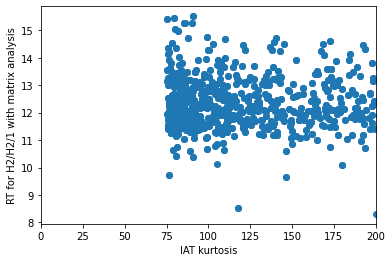

In [52]:
import matplotlib.pyplot as plt

W_arr = [x[0] for x in W_arr]
print("RT_arr :", W_arr)


plt.scatter(df_25_lam_kurt, W_arr)
plt.xlabel("IAT kurtosis")
plt.ylabel("RT for H2/H2/1 with matrix analysis")

plt.xlim(0, 200)



# How about Tarasov from stored data?

2000
In order lam1 lam2 p 1.0167811106865654 0.01924710318986305 0.9702483605960404
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  67.7291201977212
2000
2000


(0.0, 200.0)

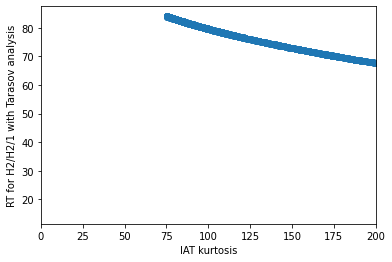

In [39]:
df_25_p = df_25['p'].to_numpy()
df_25_lam1 = df_25['lam1'].to_numpy()
df_25_lam2 = df_25['lam2'].to_numpy()
df_25_lam_kurt = df_25['lam_kurt'].to_numpy()


len_IAT = len(df_25_p)
print(len_IAT)

q_arr = [0.781]*2000
mu1_arr = [2.04463]*2000
mu2_arr = [0.15960]*2000

W_exact = Tarasov(df_25_p, df_25_lam1, df_25_lam2, q_arr, mu1_arr, mu2_arr)
print(len(df_25_lam_kurt))
print(len(W_exact))

plt.scatter(df_25_lam_kurt, W_exact)
plt.xlabel("IAT kurtosis")
plt.ylabel("RT for H2/H2/1 with Tarasov analysis")
plt.xlim(0, 200)

In [ ]:
df_121 = df[df['coeffIAT_sq'] == 1.21]

df_121_p = df_121['p'].to_numpy()
df_121_lam1 = df_121['lam1'].to_numpy()
df_121_lam2 = df_121['lam2'].to_numpy()
df_121_lam_kurt = df_121['lam_kurt'].to_numpy()


len_IAT = len(df_121)
print(len_IAT)

q_arr = [0.781]*2003
mu1_arr = [2.04463]*2003
mu2_arr = [0.15960]*2003

W_exact = Tarasov(df_121_p, df_121_lam1, df_121_lam2, q_arr, mu1_arr, mu2_arr)
print(len(df_25_lam_kurt))
print(len(W_exact))

plt.scatter(df_121_lam_kurt, W_exact)
plt.xlabel("IAT kurtosis")
plt.ylabel("RT for H2/H2/1 with Tarasov analysis")
plt.xlim(0, 200)

2003
In order lam1 lam2 p 2.248023 0.039512 0.3
In order mu1 mu2 q 2.04463 0.1596 0.781
RT  2.96939564345986
